In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm

In [2]:
t = torch.ones((5,), dtype=int).cuda()

In [10]:
t / (1 - 0.99**t)

tensor([99.9995, 99.9995, 99.9995, 99.9995, 99.9995], device='cuda:0')

In [2]:
class CustMod(nn.Module):
    def __init__(self):
        '''
        Arbitrary feed forward network. CBP assumption: forward is a single call of a Sequential layer
        '''
        super(CustMod, self).__init__()
        
        self.ff = nn.Sequential(nn.Linear(2, 8), nn.ReLU(), nn.Linear(8, 1))

    def forward(self, x):
        yhat = self.ff(x)
        return yhat

In [3]:
mod = CustMod()

In [4]:
weights = [l.weight for l in mod.ff if isinstance(l, nn.Linear)]   # list of Linear weight parameters (w)
output_lin = weights[-1]
weights = weights[:-1]
weights

[Parameter containing:
 tensor([[ 0.0730, -0.5806],
         [-0.4027,  0.1338],
         [-0.4125,  0.1988],
         [ 0.3018,  0.4534],
         [-0.1654,  0.1518],
         [ 0.6921, -0.3879],
         [-0.1804, -0.1405],
         [-0.5986, -0.2728]], requires_grad=True)]

In [5]:
units = [a for a in mod.ff if a.__module__.endswith('activation')] #+ ([mod.ff[-1]] if not mod.ff[-1].__module__.endswith('activation') else [])  # hook placements for feature outputs (h)
                                                                                                                                                 # calculate running average (fhat) in hook
    #cut off output activation? (e.g. softmax)
units

[ReLU()]

In [338]:
hs = [torch.zeros(w.shape[0]) for w in weights]
hs

[tensor([0., 0., 0., 0., 0., 0., 0., 0.])]

In [339]:
fs = [torch.zeros(w.shape[0]) for w in weights]
fs

[tensor([0., 0., 0., 0., 0., 0., 0., 0.])]

In [340]:
ages = [torch.zeros(w.shape[0], dtype=int) for w in weights]

In [341]:
fhats = [torch.zeros(w.shape[0]) for w in weights]

In [342]:
us = [torch.zeros(w.shape[0]) for w in weights]

In [343]:
def hook_gen(pos, eta):
    def hook(module, inp, out):
        with torch.no_grad():
            hs[pos] = out.clone().detach()
            fhats[pos] = fs[pos] / (1 - eta**ages[pos])
            fs[pos] = (1-eta)*hs[pos] + eta*fs[pos]
    return hook

In [344]:
eta = 0.99

In [345]:
for pos, unit in enumerate(units):
    unit.register_forward_hook(hook_gen(pos, eta))
mod.register_forward_pre_hook(lambda m, i: torch._foreach_add_(ages, 1))

In [346]:
hs

[tensor([0., 0., 0., 0., 0., 0., 0., 0.])]

In [352]:
mod(torch.ones(2))

tensor([0.3517], grad_fn=<AddBackward0>)

In [353]:
hs

[tensor([0.4245, 0.0000, 0.0000, 0.1980, 0.0000, 0.0000, 0.3456, 0.9702])]

In [354]:
fs

[tensor([0.0084, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0069, 0.0193])]

In [355]:
ages

[tensor([2, 2, 2, 2, 2, 2, 2, 2])]

In [356]:
fhats

[tensor([0.2133, 0.0000, 0.0000, 0.0995, 0.0000, 0.0000, 0.1737, 0.4876])]

In [357]:
pre_ws = [w.clone().detach().sum(1) for w in weights]
pre_ws

[tensor([-0.1309, -0.5833, -0.1363, -0.3002, -0.2060, -0.6435,  0.1051,  0.5762])]

In [358]:
post_ws = [w.clone().detach().sum(0) for w in weights[1:] + [output_lin]] # + [torch.ones(1)]] # add an importance of 1 for the last layer (not sure if this should even be calculated)
post_ws

[tensor([ 0.2147, -0.3095, -0.2143, -0.2454, -0.0126, -0.1973,  0.0494,  0.3447])]

In [359]:
ys = [torch.abs(h-fhat)*post_w/pre_w for h, fhat, pre_w, post_w in zip(hs, fhats, pre_ws, post_ws)]

In [360]:
us = [(1-eta)*y + eta*u for y, u in zip(ys, us)]
us

[tensor([-0.0035,  0.0000,  0.0000,  0.0008,  0.0000,  0.0000,  0.0008,  0.0029])]

In [361]:
uhats = [u / (1 - eta**a) for u, a in zip(us, ages)]
uhats

[tensor([-0.1740,  0.0000,  0.0000,  0.0405,  0.0000,  0.0000,  0.0406,  0.1451])]

In [104]:
class BitFlipEnv():
    def __init__(self, target, m=20, f=15, T=1e4):
        self.m = m
        self.f = f
        self.T = T
        self.t = 0
        self.target = target
        self.x = torch.zeros(self.m)
        self._update_obs()
        
    def get_obs(self):
        return self.x
    
    def step(self):
        y = self.target(self.x)
        #loss = ((pred - y)**2).sum()
        self._update_obs()
        return y
        
    def _update_obs(self):
        if self.t % self.T == 0:
            i = torch.randint(0, self.f, (1,))[0]
            self.x[i] = torch.logical_not(self.x[i])
        self.x[self.f:] = torch.randint(0, 2, (self.m - self.f,))
        self.t += 1

In [91]:
env = BitFlipEnv(lambda x: x.sum(), 5, 2, 5)

In [92]:
for i in range(20):
    print(env.get_obs(), env.step())

tensor([0., 1., 1., 1., 1.]) tensor(3., device='cuda:0')
tensor([0., 1., 0., 0., 1.]) tensor(4., device='cuda:0')
tensor([0., 1., 0., 0., 1.]) tensor(2., device='cuda:0')
tensor([0., 1., 0., 1., 1.]) tensor(2., device='cuda:0')
tensor([0., 0., 0., 0., 0.]) tensor(3., device='cuda:0')
tensor([0., 0., 0., 1., 0.]) tensor(0., device='cuda:0')
tensor([0., 0., 1., 0., 0.]) tensor(1., device='cuda:0')
tensor([0., 0., 0., 1., 0.]) tensor(1., device='cuda:0')
tensor([0., 0., 1., 1., 1.]) tensor(1., device='cuda:0')
tensor([1., 0., 1., 0., 1.]) tensor(3., device='cuda:0')
tensor([1., 0., 1., 1., 0.]) tensor(3., device='cuda:0')
tensor([1., 0., 1., 1., 1.]) tensor(3., device='cuda:0')
tensor([1., 0., 1., 1., 0.]) tensor(4., device='cuda:0')
tensor([1., 0., 0., 1., 1.]) tensor(3., device='cuda:0')
tensor([1., 1., 0., 1., 1.]) tensor(3., device='cuda:0')
tensor([1., 1., 1., 0., 0.]) tensor(4., device='cuda:0')
tensor([1., 1., 1., 0., 1.]) tensor(3., device='cuda:0')
tensor([1., 1., 1., 1., 1.]) te

In [113]:
21*0.7

14.7

In [106]:
def linear_init(linear):
    nn.init.uniform_(linear.weight, -1, 2)
    linear.weight.floor_()
    linear.weight.requires_grad = False
    nn.init.uniform_(linear.bias, -1, 2)
    linear.bias.floor_()
    linear.bias.requires_grad = False

class LTU(nn.Module):
    def __init__(self, m, out, beta=0.7):
        super(LTU, self).__init__()
        self.linear = nn.Linear(m, out)
        self.linear.apply(linear_init)
        self.beta = beta
        self.S = (self.linear.weight < -0.5).sum(1) + (self.linear.bias < -0.5)
        self.theta = ((m+1)*self.beta - self.S)
        
    def forward(self, x):
        p = self.linear(x)
        y = torch.zeros_like(p)
        y[p > self.theta] = 1
        return y

class BitFlipTarget(nn.Module):
    @torch.no_grad()
    def __init__(self, m=20, hidden_size=100, beta=0.7):
        super(BitFlipTarget, self).__init__()
        ltu = LTU(m, hidden_size, beta)
        lin = nn.Linear(hidden_size, 1)
        lin.apply(linear_init)
        self.ff = nn.Sequential(ltu, lin)
        
    @torch.no_grad()
    def forward(self, x):
        return self.ff(x)

In [97]:
target = BitFlipTarget().cuda()
env = BitFlipEnv(target, T=5)
for i in range(20):
    print(env.get_obs(), env.step())

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.]) tensor([-1.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.]) tensor([-1.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
        0., 1.]) tensor([-1.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0.]) tensor([-1.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.]) tensor([-1.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0.]) tensor([-1.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
        0., 1.]) tensor([-1.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
        0., 0.]) tensor(

In [2]:
class BitFlipLearner(nn.Module):
    def __init__(self, activation, m=20, hidden_size=5):
        super(BitFlipLearner, self).__init__()
        
        self.ff = nn.Sequential(nn.Linear(m, hidden_size), activation(), nn.Linear(hidden_size, 1))

    def forward(self, x):
        return self.ff(x)

In [99]:
BitFlipLearner(nn.Tanh)

BitFlipLearner(
  (ff): Sequential(
    (0): Linear(in_features=20, out_features=5, bias=True)
    (1): Tanh()
    (2): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [100]:
m = 20
f = 15
T = 100

target_hidden = 100
learner_hidden = 5
learner_activation = nn.Tanh
lr=0.001

target = BitFlipTarget(m=m, hidden_size=target_hidden).cuda()
learner = BitFlipLearner(learner_activation, m=m, hidden_size=learner_hidden).cuda()

env = BitFlipEnv(target, m=m, f=f, T=T)

optim = torch.optim.Adam(learner.parameters(), lr=lr)

losses = []

for iteration in range(10_000):
    optim.zero_grad()
    obs = env.get_obs().cuda()
    pred = learner(obs)
    y = env.step()
    loss = (pred - y)**2
    loss.backward()
    optim.step()
    losses.append(loss.cpu().detach().item())
    
losses = np.array(losses)

In [101]:
bin_size = 100
binned_losses, binned_std = np.array([(losses[l: r].mean(), losses[l: r].std()) for l, r in zip(range(0, len(losses)-bin_size+1, bin_size), range(bin_size, len(losses)+1, bin_size))]).T

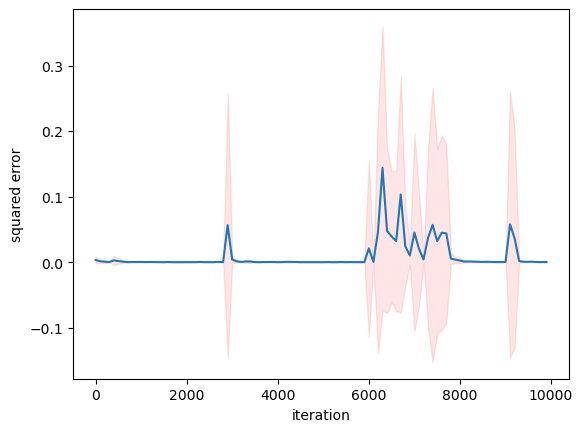

In [102]:
plt.plot(list(range(0, len(losses)-bin_size+1, bin_size)), binned_losses)
plt.fill_between(list(range(0, len(losses)-bin_size+1, bin_size)), binned_losses-binned_std, binned_losses+binned_std, color='red', alpha=0.1)
plt.xlabel('iteration')
plt.ylabel('squared error')
plt.show()

In [130]:
runs = 100
length = 1_000_000

for run in tqdm(range(runs), 'Generating training pairs', runs):
    inp = np.empty((length, 20), int)
    out = np.empty((length), int)
    
    target = BitFlipTarget(beta=0.5)
    env = BitFlipEnv(target)
    for i in range(length):
        inp[i] = env.get_obs().int()
        out[i] = env.step().int()
        
    with open(f'bitflip/ops_{run}.npy', 'wb') as f:
        np.save(f, inp)
    with open(f'bitflip/out_{run}.npy', 'wb') as f:
        np.save(f, out)

Generating training pairs:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
run = 0

with open(f'bitflip/ops_{run}.npy', 'rb') as f:
    obs = np.load(f)
with open(f'bitflip/out_{run}.npy', 'rb') as f:
    out = np.load(f)

In [137]:
learner = BitFlipLearner(nn.Tanh).cuda()

#optim = torch.optim.Adam(learner.parameters(), lr=0.001)
optim = torch.optim.SGD(learner.parameters(), lr=0.01)

losses = []

for x, y in tqdm(zip(obs, out), 'Training', len(obs)):
    optim.zero_grad()
    pred = learner(torch.from_numpy(x).float().cuda())
    loss = (y - pred)**2
    loss.backward()
    optim.step()
    losses.append(loss.cpu().detach().item())

Training:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [138]:
losses = np.array(losses)

In [139]:
bin_size = 20_000
binned_losses, binned_std = np.array([(losses[l: r].mean(), losses[l: r].std()) for l, r in zip(range(0, len(losses)-bin_size+1, bin_size), range(bin_size, len(losses)+1, bin_size))]).T

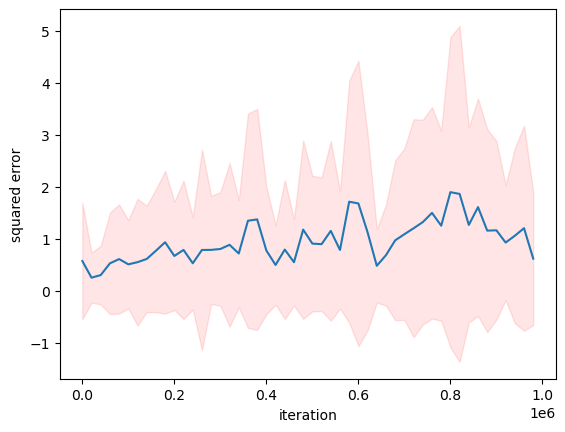

In [140]:
plt.plot(list(range(0, len(losses)-bin_size+1, bin_size)), binned_losses)
plt.fill_between(list(range(0, len(losses)-bin_size+1, bin_size)), binned_losses-binned_std, binned_losses+binned_std, color='red', alpha=0.1)
plt.xlabel('iteration')
plt.ylabel('squared error')
plt.show()

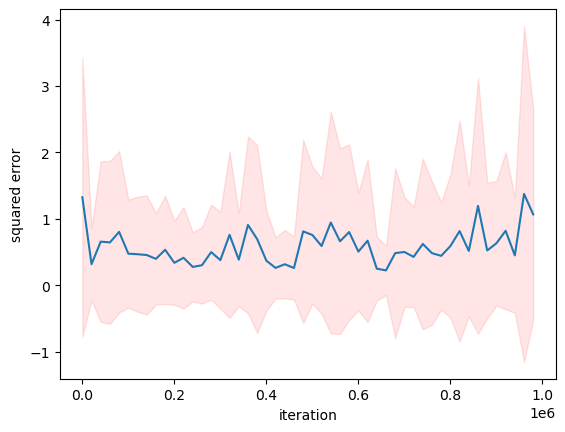

In [27]:
import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer
from typing import List, Optional
from torch.optim import Adam


class CAdam(Adam):
    r"""
    Barebone Adam adaptation with 'step' parameter for each weight in a parameter Tensor, instead of one number for the whole Tensor
    """

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        self._cuda_graph_capture_health_check()

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                    grads.append(p.grad)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        ### CHANGED ###
                        #state['step'] = torch.zeros((1,), dtype=torch.float, device=p.device) \
                        #    if self.defaults['capturable'] else torch.tensor(0.)
                        state['step'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        ###############
                        
                        
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        if group['amsgrad']:
                            # Maintains max of all exp. moving avg. of sq. grad. values
                            state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['max_exp_avg_sq'])

                    state_steps.append(state['step'])

            cadam(params_with_grad,
                 grads,
                 exp_avgs,
                 exp_avg_sqs,
                 max_exp_avg_sqs,
                 state_steps,
                 amsgrad=group['amsgrad'],
                 beta1=beta1,
                 beta2=beta2,
                 lr=group['lr'],
                 weight_decay=group['weight_decay'],
                 eps=group['eps'],
                 maximize=group['maximize'],
                 foreach=group['foreach'],
                 capturable=group['capturable'])

        return loss


def cadam(params: List[Tensor],
         grads: List[Tensor],
         exp_avgs: List[Tensor],
         exp_avg_sqs: List[Tensor],
         max_exp_avg_sqs: List[Tensor],
         state_steps: List[Tensor],
         # kwonly args with defaults are not supported by functions compiled with torchscript issue #70627
         # setting this as kwarg for now as functional API is compiled by torch/distributed/optim
         foreach: bool = None,
         capturable: bool = False,
         *,
         amsgrad: bool,
         beta1: float,
         beta2: float,
         lr: float,
         weight_decay: float,
         eps: float,
         maximize: bool):
    r"""Functional API that performs Adam algorithm computation.
    See :class:`~torch.optim.Adam` for details.
    """

    if not all([isinstance(t, torch.Tensor) for t in state_steps]):
        raise RuntimeError("API has changed, `state_steps` argument must contain a list of singleton tensors")

    if foreach is None:
        # Placeholder for more complex foreach logic to be added when value is not set
        foreach = False

    if foreach and torch.jit.is_scripting():
        raise RuntimeError('torch.jit.script not supported with foreach optimizers')

    if foreach and not torch.jit.is_scripting():
        ### CHANGED ###
        #func = _multi_tensor_adam
        raise NotImplementedError()
        ###############
    else:
        func = _single_tensor_cadam

    func(params,
         grads,
         exp_avgs,
         exp_avg_sqs,
         max_exp_avg_sqs,
         state_steps,
         amsgrad=amsgrad,
         beta1=beta1,
         beta2=beta2,
         lr=lr,
         weight_decay=weight_decay,
         eps=eps,
         maximize=maximize,
         capturable=capturable)


def _single_tensor_cadam(params: List[Tensor],
                        grads: List[Tensor],
                        exp_avgs: List[Tensor],
                        exp_avg_sqs: List[Tensor],
                        max_exp_avg_sqs: List[Tensor],
                        state_steps: List[Tensor],
                        *,
                        amsgrad: bool,
                        beta1: float,
                        beta2: float,
                        lr: float,
                        weight_decay: float,
                        eps: float,
                        maximize: bool,
                        capturable: bool):

    for i, param in enumerate(params):

        grad = grads[i] if not maximize else -grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step_t = state_steps[i]

        if capturable:
            assert param.is_cuda and step_t.is_cuda, "If capturable=True, params and state_steps must be CUDA tensors."

        # update step
        # update step
        ### CHANGED ###
        #step_t += 1
        step_t.add_(1)
        ###############

        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)

        if capturable:
            ### CHANGED ###
            # code
            raise NotImplementedError()
            ###############
        else:
            ### CHANGED ###
            #step = step_t.item()
            step = step_t
            ###############

            bias_correction1 = 1 - beta1 ** step
            bias_correction2 = 1 - beta2 ** step

            step_size = lr / bias_correction1

            ### CHANGED ###
            #bias_correction2_sqrt = math.sqrt(bias_correction2)
            bias_correction2_sqrt = bias_correction2.sqrt()
            ###############

            if amsgrad:
                # Maintains the maximum of all 2nd moment running avg. till now
                torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
                # Use the max. for normalizing running avg. of gradient
                denom = (max_exp_avg_sqs[i].sqrt() / bias_correction2_sqrt).add_(eps)
            else:
                denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt).add_(eps)

            ### CHANGED ###
            #param.addcdiv_(exp_avg, denom, value=-step_size)
            param.sub_((exp_avg / denom).mul_(step_size))
            ###############

In [18]:
learner = BitFlipLearner(nn.Tanh)

In [19]:
state = learner.state_dict()

In [20]:
learner.load_state_dict(state)
model = learner.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.001)

real_losses = []

for x, y in tqdm(zip(obs[:1000], out[:1000]), 'Training', len(obs[:1000])):
    optim.zero_grad()
    pred = model(torch.from_numpy(x).float().cuda())
    loss = (y - pred)**2
    loss.backward()
    optim.step()
    real_losses.append(loss.cpu().detach().item())
    
real_losses = np.array(real_losses)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
bin_size = 10
real_binned_losses, real_binned_std = np.array([(real_losses[l: r].mean(), real_losses[l: r].std()) for l, r in zip(range(0, len(real_losses)-bin_size+1, bin_size), range(bin_size, len(real_losses)+1, bin_size))]).T

In [29]:
learner.load_state_dict(state)
model = learner.cuda()

optim = CAdam(model.parameters(), lr=0.001)

new_losses = []

for x, y in tqdm(zip(obs[:1000], out[:1000]), 'Training', len(obs[:1000])):
    optim.zero_grad()
    pred = model(torch.from_numpy(x).float().cuda())
    loss = (y - pred)**2
    loss.backward()
    optim.step()
    new_losses.append(loss.cpu().detach().item())
    
new_losses = np.array(new_losses)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
bin_size = 10
new_binned_losses, new_binned_std = np.array([(new_losses[l: r].mean(), new_losses[l: r].std()) for l, r in zip(range(0, len(new_losses)-bin_size+1, bin_size), range(bin_size, len(new_losses)+1, bin_size))]).T

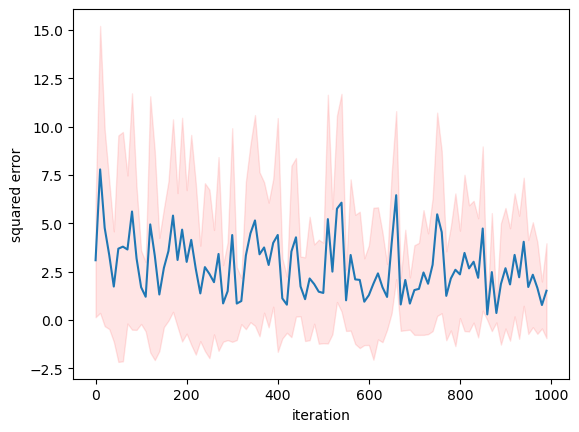

In [24]:
plt.plot(list(range(0, len(real_losses)-bin_size+1, bin_size)), real_binned_losses)
plt.fill_between(list(range(0, len(real_losses)-bin_size+1, bin_size)), real_binned_losses-real_binned_std, real_binned_losses+real_binned_std, color='red', alpha=0.1)
plt.xlabel('iteration')
plt.ylabel('squared error')
plt.show()

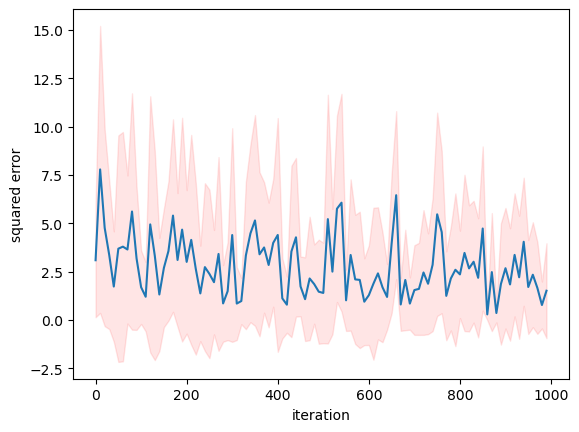

In [25]:
plt.plot(list(range(0, len(new_losses)-bin_size+1, bin_size)), new_binned_losses)
plt.fill_between(list(range(0, len(new_losses)-bin_size+1, bin_size)), new_binned_losses-new_binned_std, new_binned_losses+new_binned_std, color='red', alpha=0.1)
plt.xlabel('iteration')
plt.ylabel('squared error')
plt.show()

In [30]:
np.abs(real_losses - new_losses).sum()

0.006384075796177058

In [59]:
optim.state[list(model.parameters())[0]]

{'step': tensor([[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
          1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
         [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
          1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
         [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
          1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
         [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
          1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
         [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
          1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]],
        device='cuda:0'),
 'exp_avg': tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.2191,  0.0000,  0.

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm

In [2]:
import gym
import pybulletgym

In [3]:
#env = gym.make("CartPole-v1")
env = gym.make("AntMuJoCoEnv-v0")

WalkerBase::__init__


C:\Users\chris\anaconda3\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [5]:
from stable_baselines3.ppo import PPO

In [6]:
from optim import CAdam
import math

class CBP(CAdam):
    '''
    Open questions:
        How should batches be dealth with?
            For now I calculate the mean over the batch and handle that like in the sequential case
        How many features are actually replaced every iteration? Their n_l and rho don't seem to work, as 256 * 10**-4 < 1. Is this supposed to be a probability?
            # For now math.ceil is used, so every iteration 1 usit is replaced. This doesn't make sense, since when n_l < m then the features are just replaced in order as they mature.
            Changed to using n_l * rho as a probability of replacing the worst performing feature
    '''
    def __init__(self,
                 params,                 # all parameters to be optimized by Adam
                 linear_layers,          # List[List[Linear]], a list of linearities for each separate network (policy, value, ...), in the order they are executed
                 activation_layers,      # List[List[Activation]], a list of activation layers for each separate network (policy, value, ...), in the order they are executed. Forward hooks are added to these
                 output_linears,         # List[Linear], a list of each network's last Linear layer
                 eta=0.99,               # running average discount factor
                 m=int(5e3),             # maturity threshold, only features with age > m are elligible to be replaced
                 rho=10**-4,             # replacement rate, controls how frequently features are replaced                                                    # TODO: change description
                 sample_weights=None,    # functiion, take size and device as input and return a tensor of the given size with newly initialized weights
                 eps=1e-8,               # small additive value to avoid division by zero
                 device = 'auto',
                 **kwargs):
        super(CBP, self).__init__(params, **kwargs)
        self.linear_layers = linear_layers
        self.activation_layers = activation_layers
        self.cbp_vals = {}
        self.output_linears = output_linears
        self.eta = eta
        self.m = m
        self.rho = rho
        
        self.dev = get_device(device)
        
        assert len(self.linear_layers) == len(self.activation_layers)
        for linears, activations in zip(self.linear_layers, self.activation_layers):
            self._add_hooks(linears, activations)
        
        if sample_weights is None:
            def sample_weights(size, device):
                sample = torch.empty(size, device=device)
                torch.nn.init.kaiming_uniform_(sample, a=math.sqrt(5))
                return sample
            reset_weights = lambda w: torch.nn.init.kaiming_uniform_(w, a=math.sqrt(5))
        self.sample_weights = sample_weights
        self.eps = eps
    
    @torch.no_grad()
    def step(self):
        super(CBP, self).step()
        for linears, output_linear in zip(self.linear_layers, self.output_linears): # cycle through models
            # TODO change such that abs is not called twice on each weight Tensor
            for current_linear, next_linear in zip(linears, linears[1:] + [output_linear]): # cycle through layers
                cbp_vals = self.cbp_vals[current_linear]
                
                pre_w = current_linear.weight.abs().sum(1).detach_().add_(self.eps) # avoid division by zero
                post_w = next_linear.weight.abs().sum(0).detach_()
                
                y = (cbp_vals['h'] - cbp_vals['fhat']).abs_().mul_(post_w).div_(pre_w)
                cbp_vals['u'].mul_(self.eta).add_((1-self.eta)*y)
                
                uhat = cbp_vals['u'] / (1 - self.eta**cbp_vals['age'])
                
                eligible = cbp_vals['age'] > self.m
                if eligible.any() and torch.rand(1) < len(uhat)*self.rho:  # use n_l* rho as a probability of replacing a single feature
                    ascending = uhat.argsort()
                    r = ascending[eligible[ascending]]   # sort eligible indices according to their utility
                    #r = r[:math.ceil(uhat.shape[0]*self.rho)]  # choose top k worst performing features    # using ceil because otherwise nothing ever gets reset int(256*10**-4)=0
                    r = r[[0]]  # choose the worst feature
                    
                    current_linear.weight.index_copy_(0, r, self.sample_weights((len(r), current_linear.weight.shape[1]), device=current_linear.weight.device))
                    next_linear.weight.index_fill_(1, r, 0.)
                    
                    cbp_vals['u'].index_fill_(0, r, 0.)
                    cbp_vals['f'].index_fill_(0, r, 0.)
                    cbp_vals['age'].index_fill_(0, r, 0)
                    
                    ### Adam resets
                    pre_state = self.state[current_linear.weight]
                    pre_state['step'].index_fill_(0, r, 0)
                    pre_state['exp_avg'].index_fill_(0, r, 0.)
                    pre_state['exp_avg_sq'].index_fill_(0, r, 0.)
                    
                    post_state = self.state[next_linear.weight]
                    post_state['step'].index_fill_(1, r, 0)
                    post_state['exp_avg'].index_fill_(1, r, 0.)
                    post_state['exp_avg_sq'].index_fill_(1, r, 0.)
                    
    def _hook_gen(self, linear_layer):
        num_units = linear_layer.weight.shape[0]
        self.cbp_vals[linear_layer] = {
            'age':  torch.zeros(num_units, dtype=int, device=self.dev), 
            'h':    torch.zeros(num_units, device=self.dev),
            'f':    torch.zeros(num_units, device=self.dev),
            'fhat': torch.zeros(num_units, device=self.dev),
            'u':    torch.zeros(num_units, device=self.dev)
        }
        def hook(mod, inp, out):
            if mod.training:
                with torch.no_grad():
                    # NOTE Seems CBP is only described for sequential input with gradient updates at each step.
                    #      Since PPO is based on batched environment data, changes have to be made
                    #      I will therefore work with means over the baches
                    cbp_vals = self.cbp_vals[linear_layer]
                    cbp_vals['age'].add_(1)
                    cbp_vals['h'] = out.mean(0).detach_()
                    cbp_vals['fhat'] = self.cbp_vals[linear_layer]['f'] / (1 - self.eta**cbp_vals['age'])
                    cbp_vals['f'].mul_(self.eta).add_((1-self.eta)*cbp_vals['h'])
        return hook
    
    def _add_hooks(self, linears, activations):
        assert len(linears) == len(activations
                                  )
        for lin, act in zip(linears, activations):
            act.register_forward_hook(self._hook_gen(lin))

In [7]:
from stable_baselines3.ppo.policies import ActorCriticPolicy
from stable_baselines3.common.utils import get_device

class CPPO_Policy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space,
        action_space,
        lr_schedule,
        **kwargs
    ):
        assert not 'optimizer_class' in kwargs
        super(CPPO_Policy, self).__init__(observation_space, action_space, lr_schedule, **(kwargs|{'optimizer_kwargs':{}})) # remove optimizer_kwargs, as __init__ initializes Adam with them, which throws errors
        self.optimizer_kwargs = kwargs['optimizer_kwargs']
        assert len(self.mlp_extractor.shared_net) == 0, 'no shared layers between policy and value function allowed' # not used in the paper, might try to implement it later
        
        policy_linears, policy_activations = self._handle_sequential(self.mlp_extractor.policy_net)
        value_linears, value_activations = self._handle_sequential(self.mlp_extractor.value_net)
        
        self.optimizer = CBP(self.parameters(),
                             linear_layers=[policy_linears, value_linears],
                             activation_layers=[policy_activations, value_activations],
                             output_linears=[self.action_net, self.value_net],
                             lr=lr_schedule(1),
                             **self.optimizer_kwargs)
    
    def _handle_sequential(self, sequential):
        linears = []
        activations = []
        for i, layer in enumerate(sequential):
            if i%2 == 0: # Linear Layer
                linears.append(layer)
            else:        # Activation Layer
                activations.append(layer)
        return linears, activations

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm

import gym
import pybulletgym

from stable_baselines3.ppo import PPO

from cppo import CPPO_Policy

In [2]:
ppo = PPO(CPPO_Policy, "AntMuJoCoEnv-v0", 
        policy_kwargs={'net_arch': [{'pi': [256, 256], 'vf':[256, 256]}], 
                       'activation_fn': nn.Tanh, 
                       'optimizer_kwargs':{'m':10}})

C:\Users\chris\anaconda3\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


WalkerBase::__init__


In [3]:
ppo.learn(total_timesteps=10)

In [2]:
env = gym.make("AntMuJoCoEnv-v0")

WalkerBase::__init__


C:\Users\chris\anaconda3\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [10]:
env.reset()

array([ 0.75      ,  0.        ,  0.        ,  0.        ,  1.        ,
       -0.01282061, -0.09577501,  0.07053206,  0.09939641, -0.03495903,
       -0.03378454,  0.03809717, -0.06505393,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [11]:
env.env._p

In [20]:
env.env._p.getBaseVelocity(env.env.robot_body.bodies[env.env.robot_body.bodyIndex])

((0.0, 0.0, 0.0), (0.0, 0.0, 0.0))

In [21]:
env.env._p.getDynamicsInfo(env.env.robot_body.bodies[env.env.robot_body.bodyIndex], -1)

(65.44984694978736,
 1.5,
 (1.636246173744684, 1.636246173744684, 1.636246173744684),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 0.0, 1.0),
 0.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 2,
 0.25)

In [42]:
# default lateral friction = 1.5
# goal: log sample from [1e-4, 1e4]  # 1e2 - 1e4 might not be much change? As soon as the robot doesn't slide, more friction doesn't change anything

In [36]:
10**np.random.uniform(-4, 4)

0.0006233877294548615

In [41]:
env.env._p.changeDynamics(env.env.robot_body.bodies[env.env.robot_body.bodyIndex], -1, lateralFriction=10**np.random.uniform(-4, 4))

env.env._p.getDynamicsInfo(env.env.robot_body.bodies[env.env.robot_body.bodyIndex], -1)

(65.44984694978736,
 6652.517210959894,
 (1.636246173744684, 1.636246173744684, 1.636246173744684),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 0.0, 1.0),
 0.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 2,
 0.25)

In [54]:
import numpy as np
from pybulletgym.envs.mujoco.envs.locomotion.ant_env import AntMuJoCoEnv

class SlindingAntEnv(AntMuJoCoEnv):
    '''
    Change the friction between Ant and Floor every change_steps timesteps to a random number between 10**log_low and 10**log_high
    '''
    def __init__(self, change_steps, log_low=-4, log_high=4):
        super(SlindingAntEnv, self).__init__()
        self.change_steps = change_steps
        self.log_low = log_low
        self.log_high = log_high
        self.counter = 0 # won't be reset when the environment is reset
        
    def step(self, a):
        ret = super(SlindingAntEnv, self).step(a)
        self.counter += 1
        if self.counter == self.change_steps:
            self.counter = 0
            self._p.changeDynamics(self.robot_body.bodies[self.robot_body.bodyIndex], -1, lateralFriction=10**np.random.uniform(self.log_low, self.log_high))
        return ret

In [55]:
env = SlindingAntEnv(3)

WalkerBase::__init__


C:\Users\chris\anaconda3\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [56]:
ppo = PPO(CPPO_Policy, env, 
        policy_kwargs={'net_arch': [{'pi': [256, 256], 'vf':[256, 256]}], 
                       'activation_fn': nn.Tanh, 
                       'optimizer_kwargs':{'m':10}})

In [57]:
ppo.learn(total_timesteps=10)

In [59]:
env._p.getDynamicsInfo(env.robot_body.bodies[env.robot_body.bodyIndex], -1)

(65.44984694978736,
 0.004875707641373354,
 (1.636246173744684, 1.636246173744684, 1.636246173744684),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 0.0, 1.0),
 0.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 2,
 0.25)

In [60]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm

import gym
import pybulletgym

from stable_baselines3.ppo import PPO

from cppo import CPPO_Policy
from env import SlindingAntEnv

In [61]:
env = SlindingAntEnv(3)

WalkerBase::__init__


C:\Users\chris\anaconda3\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [64]:
env.reset()
print('friction:', env._p.getDynamicsInfo(env.robot_body.bodies[env.robot_body.bodyIndex], -1)[1])

friction: 1.5


In [65]:
ppo = PPO(CPPO_Policy, env, 
        policy_kwargs={'net_arch': [{'pi': [256, 256], 'vf':[256, 256]}], 
                       'activation_fn': nn.Tanh, 
                       'optimizer_kwargs':{'m':10}})

In [66]:
ppo.learn(total_timesteps=10)

In [67]:
print('friction:', env._p.getDynamicsInfo(env.robot_body.bodies[env.robot_body.bodyIndex], -1)[1])

friction: 3870.914906190144
